# MBO Sparse Maps

This tutorial illustrates how using ``elastic`` costs of the form

$$
c(x, y) = h_\tau(x - y)\text{ with } h_\tau(z) = \frac12\|z\|^2_2 + \lambda \tau(z),
$$

when estimating Monge maps that are optimal for that cost results in displacement that have structure. In full generality $\tau$ can be any regularizer that has a proximal operator known in closed form. We will consider in particular the $\ell_1$ sparsity-inducing norm.

Entropic Monge maps estimated from samples using such a cost exhibit sparsity in displacements: every input point is transported to another target point by only changing a subset of its features.

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import costs, pointcloud, regularizers
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

## Sampling 2D point clouds


In [2]:
n_source = 30
n_target = 50
n_test = 10
p = 2

keys = jax.random.split(jax.random.key(0), 4)
x = jax.random.normal(keys[0], (n_source, p))

y0 = jax.random.normal(keys[1], (n_target // 2, p)) + jnp.array([5, 0])
y1 = jax.random.normal(keys[2], (n_target // 2, p)) + jnp.array([0, 8])
y = jnp.concatenate([y0, y1])

In [3]:
# Plotting utility


def plot_map(x, y, x_new=None, z=None, ax=None, title=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 8))

    ax.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$")
    ax.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$")
    if z is not None:
        ax.quiver(
            *x_new.T,
            *(z - x_new).T,
            color="k",
            angles="xy",
            scale_units="xy",
            scale=1,
            width=0.007,
        )
        ax.scatter(
            *x_new.T, s=150, edgecolors="k", marker="o", label="$x_{new}$"
        )
        ax.scatter(
            *z.T,
            s=150,
            edgecolors="k",
            marker="X",
            label=r"$T_{x\rightarrow y}(x_{new})$",
        )
    if title is not None:
        ax.set_title(title)
    ax.legend(fontsize=22)

The source samples $x$ are drawn from a Gaussian distribution, while the target samples $y$ are drawn from a mixture of two Gaussians.

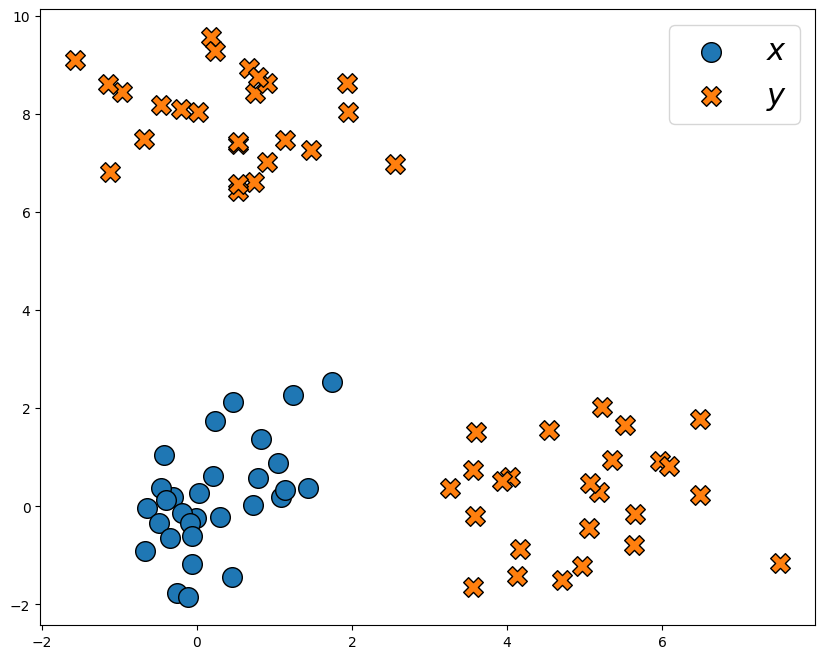

In [4]:
plot_map(x, y)

We also draw some fresh unseen samples from the source distribution:

In [5]:
n_new = 10
x_new = jax.random.normal(keys[3], (n_new, p))

## Standard entropic Monge map

We first compute the "standard" {class}`entropic map <ott.problems.linear.potentials.EntropicPotentials>` between these two distributions using the $\ell_2^2$ cost. Following {cite}`pooladian:21`, we compute the solution of {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` on the problem, and then use `OTT` to turn these solutions into a pair of {class}`dual potentials <ott.problems.linear.potentials.DualPotentials>` functions.

These dual potentials are then used to build the entropic map with the {meth}`~ott.problems.linear.potentials.DualPotentials.transport` method.

In [6]:
# jit first a Sinkhorn solver.
solver = jax.jit(sinkhorn.Sinkhorn())


def entropic_map(x, y, cost_fn: costs.TICost) -> jnp.ndarray:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport


map = entropic_map(x, y, costs.SqEuclidean())

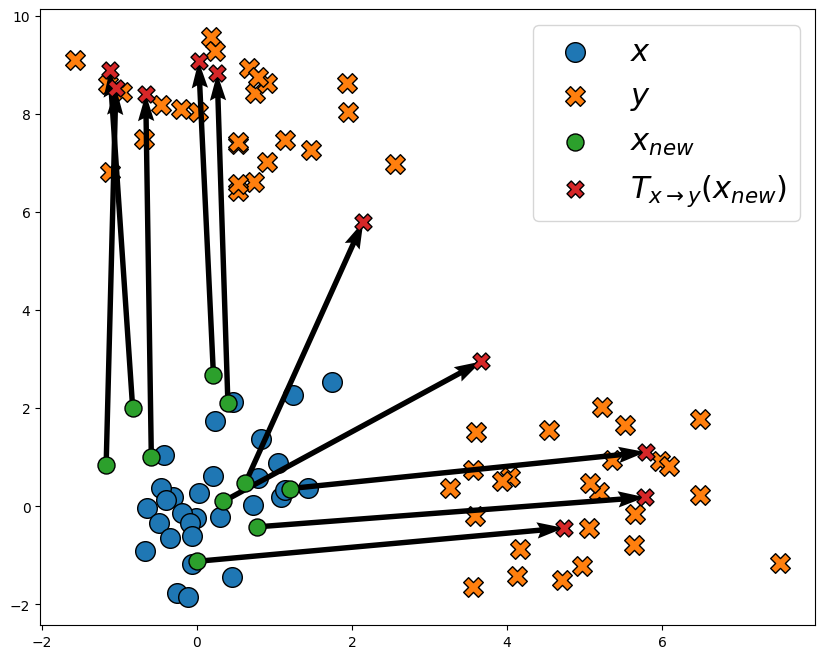

In [7]:
plot_map(x, y, x_new, map(x_new))

We see that the displacements have no particular structure.

## Sparse Monge displacements

We now turn to regularized costs, with the {class}`~ott.geometry.costs.RegTICost` with an {class}`~ott.geometry.regularizers.L1` regularizer that corresponds to:

$$
h(z) = \frac12\|z\|_2^2 + \lambda \|z\|_1.
$$

In [8]:
reg = regularizers.L1()
map_l1 = entropic_map(x, y, costs.RegTICost(reg, lam=10.0))

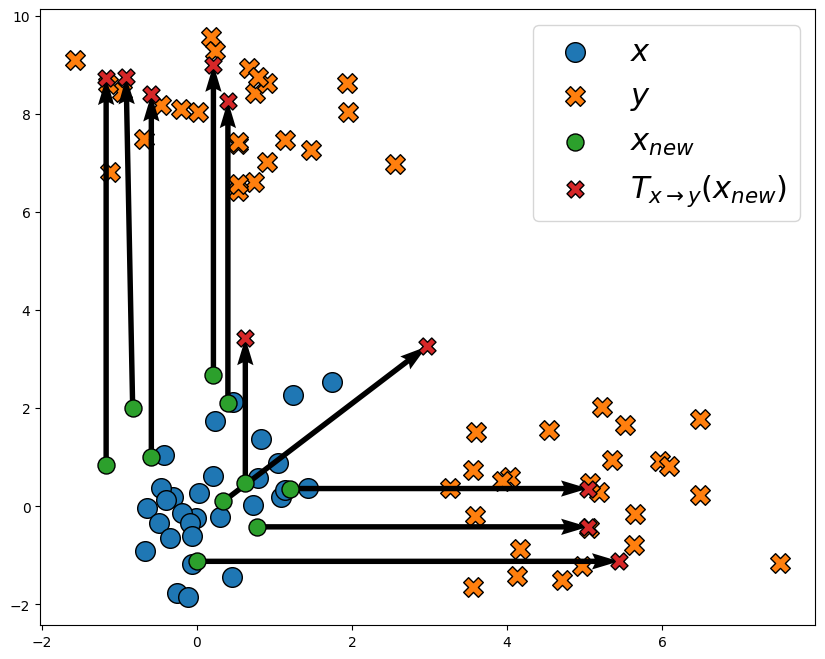

In [9]:
plot_map(x, y, x_new, map_l1(x_new))

We now see that most samples have a sparse displacement patterns: for most samples, only one coordinate is changed. In this case, that coordinate depends on the sample: some samples move only along the `x-axis`, while other move only along the `y-axis`. Some points also move along both axes.

We can investigate the effect of the regularization strength $\lambda$ on the estimated maps:

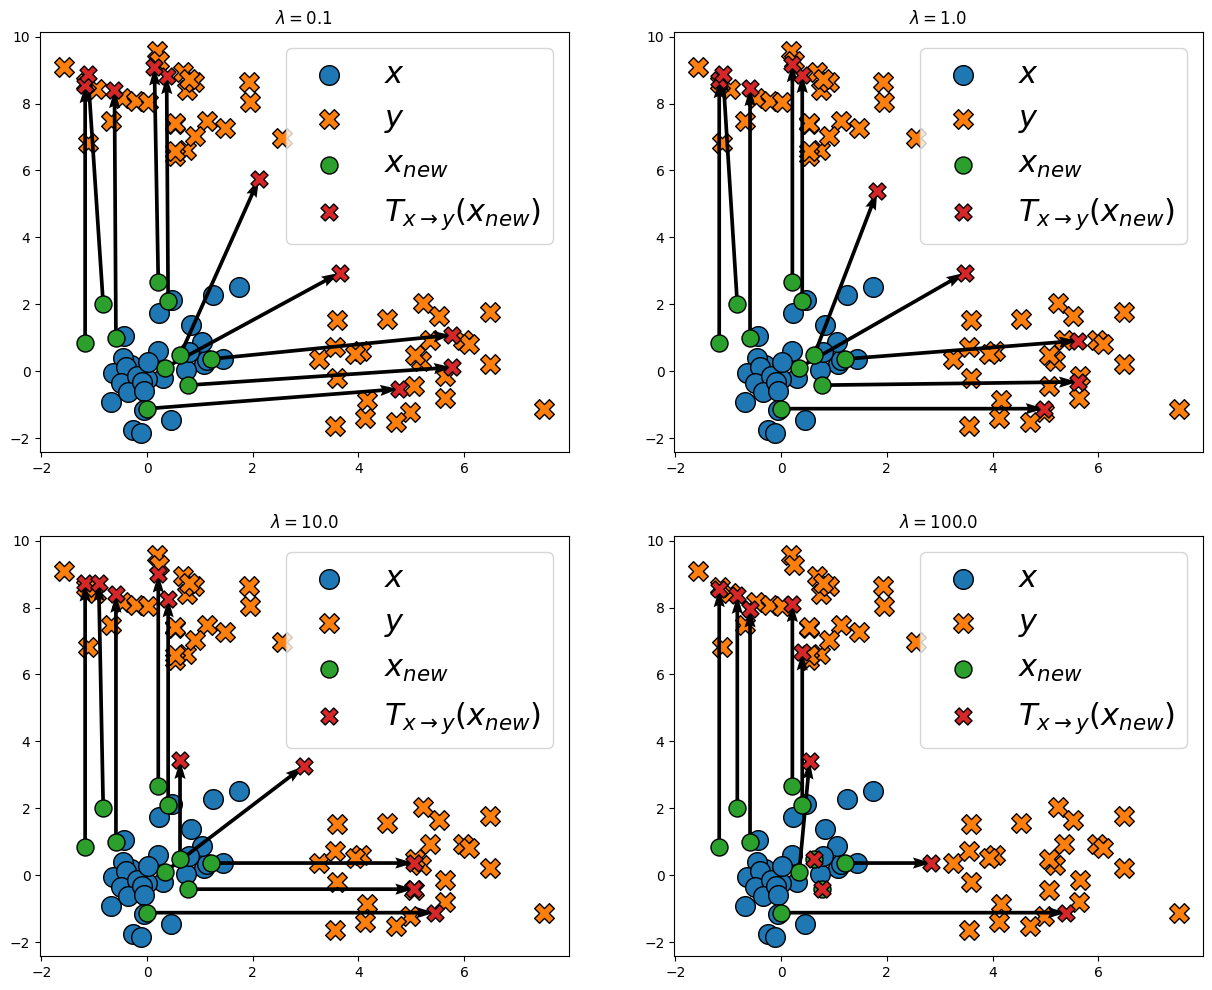

In [10]:
lambdas = [0.1, 1.0, 10.0, 100.0]

f, axes = plt.subplots(2, 2, figsize=(15, 12))
for lam, ax in zip(lambdas, axes.ravel()):
    reg = regularizers.L1()
    map = entropic_map(x, y, costs.RegTICost(reg, lam=lam))
    plot_map(
        x,
        y,
        x_new,
        map(x_new),
        ax=ax,
        title=rf"$\lambda = {lam}$",
    )

We see that a low $\lambda$ leads to no sparsity in the displacements. Increasing $\lambda$, sparsity starts appearing. Taking a really high $\lambda$ also leads to a large shrinkage, as evident in the last plot.

We can also consider other sparsity inducing norms like the $k$-overlap introduced {cite}`argyriou:12`:

$$
h(z) = \frac12\|z\|_2^2 + \frac\lambda2\ \left(\|z\|^k_{\text{ov}}\right)^2
$$

In [11]:
reg = regularizers.SqKOverlap(1)
map = entropic_map(x, y, costs.RegTICost(reg, lam=1.0))

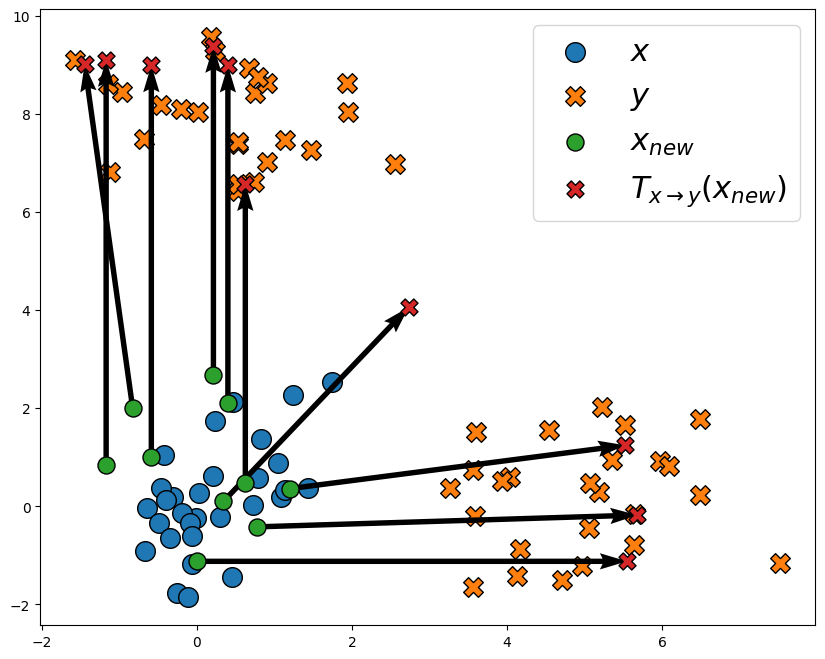

In [12]:
plot_map(x, y, x_new, map(x_new))

This cost induces less shrinkage, but requires more computational effort than the simple soft-thresholding operator.